In [54]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping


from google.colab import drive
drive.mount('/content/drive/')
df = pd.read_csv('/content/drive/My Drive/Lab/NSE_Data.csv',index_col='Date',parse_dates=True)
print('Number of rows and columns:', df.shape)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Number of rows and columns: (1481, 6)


In [55]:
df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,7924.549805,7937.549805,7781.100098,7791.299805,7791.299805,134700.0
2016-01-05,7828.399902,7831.200195,7763.250000,7784.649902,7784.649902,145200.0
2016-01-06,7788.049805,7800.950195,7721.200195,7741.000000,7741.000000,147100.0
2016-01-07,7673.350098,7674.950195,7556.600098,7568.299805,7568.299805,188900.0
2016-01-08,7611.649902,7634.100098,7581.049805,7601.350098,7601.350098,157400.0


In [57]:
df.isna().any()

Open         True
High         True
Low          True
Close        True
Adj Close    True
Volume       True
dtype: bool

In [58]:
df.isnull().sum()

Open         6
High         6
Low          6
Close        6
Adj Close    6
Volume       6
dtype: int64

In [63]:
df= df.fillna(df.mean())

In [64]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1481 entries, 2016-01-04 to 2021-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1481 non-null   float64
 1   High       1481 non-null   float64
 2   Low        1481 non-null   float64
 3   Close      1481 non-null   float64
 4   Adj Close  1481 non-null   float64
 5   Volume     1481 non-null   float64
dtypes: float64(6)
memory usage: 81.0 KB


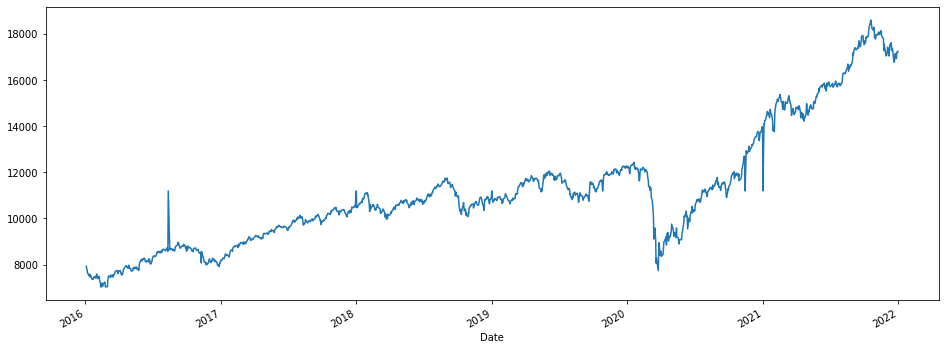

In [66]:
df['Open'].plot(figsize=(16,6))

In [72]:
df.rolling(7).mean().head(20)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-07,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-08,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-11,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-12,7705.807129,7724.592913,7626.478586,7651.535645,7651.535645,160885.714286
2016-01-13,7653.428571,7675.078683,7575.721401,7618.835659,7618.835659,172385.714286
2016-01-14,7601.857143,7642.735770,7530.085659,7583.428502,7583.428502,180328.571429


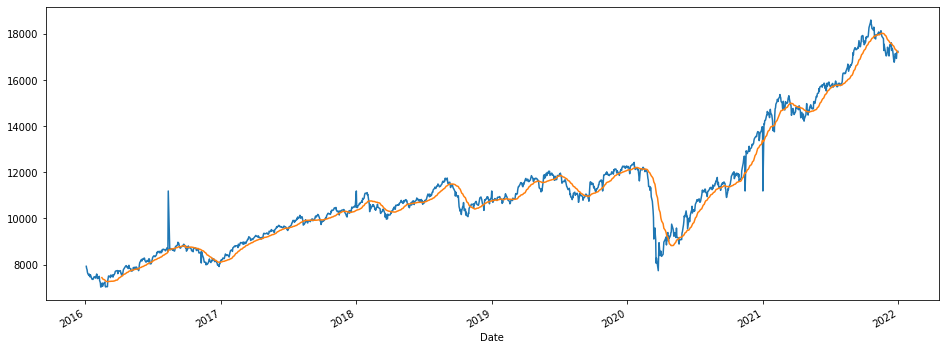

In [73]:
df['Open'].plot(figsize=(16,6))
df.rolling(window=30).mean()['Close'].plot()

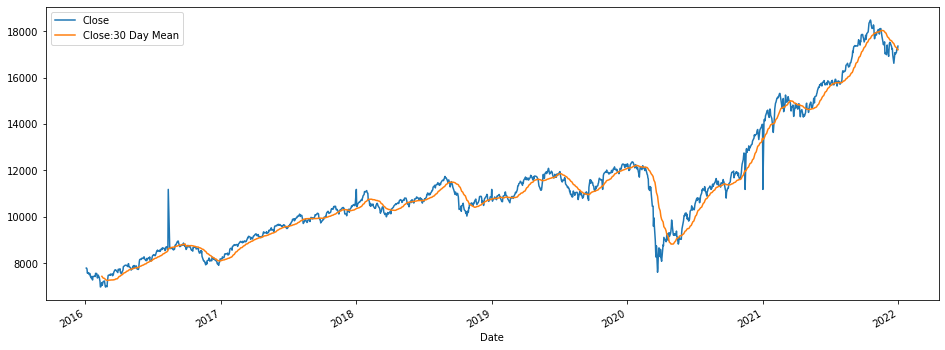

In [74]:
df['Close:30 Day Mean'] = df['Close'].rolling(window=30).mean()
df[['Close','Close:30 Day Mean']].plot(figsize=(16,6))

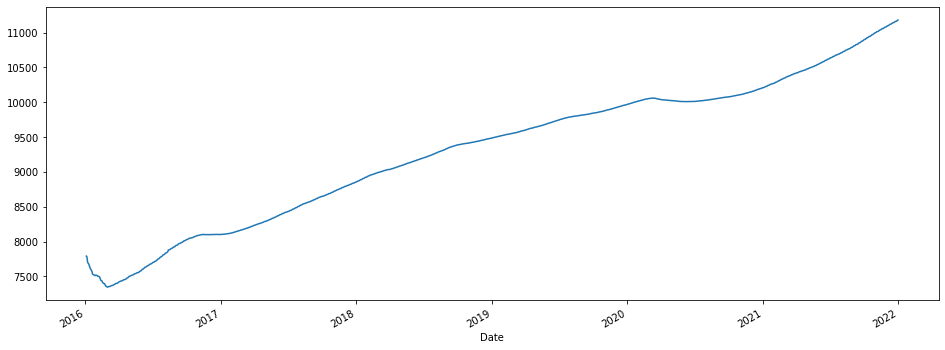

In [75]:
df['Close'].expanding(min_periods=1).mean().plot(figsize=(16,6))

In [76]:
train = df['Open']
train = pd.DataFrame(train)

In [77]:
train

,Open
Date,
2016-01-04,7924.549805
2016-01-05,7828.399902
2016-01-06,7788.049805
2016-01-07,7673.350098
2016-01-08,7611.649902
...,...
2021-12-27,16937.750000
2021-12-28,17177.599609
2021-12-29,17220.099609


In [78]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
train = sc.fit_transform(train)

In [79]:
X_train = []
y_train = []
for i in range(60, 1481):
    X_train.append(train[i-60:i, 0])
    y_train.append(train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
#reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [80]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

In [81]:
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
45/45 [==============================] - 14s 127ms/step - loss: 0.0272
Epoch 2/30
45/45 [==============================] - 6s 127ms/step - loss: 0.0040
Epoch 3/30
45/45 [==============================] - 6s 127ms/step - loss: 0.0036
Epoch 4/30
45/45 [==============================] - 6s 129ms/step - loss: 0.0033
Epoch 5/30
45/45 [==============================] - 6s 128ms/step - loss: 0.0030
Epoch 6/30
45/45 [==============================] - 6s 129ms/step - loss: 0.0031
Epoch 7/30
45/45 [==============================] - 10s 217ms/step - loss: 0.0029
Epoch 8/30
45/45 [==============================] - 6s 127ms/step - loss: 0.0025
Epoch 9/30
45/45 [==============================] - 6s 129ms/step - loss: 0.0029
Epoch 10/30
45/45 [==============================] - 6s 144ms/step - loss: 0.0025
Epoch 11/30
45/45 [==============================] - 7s 159ms/step - loss: 0.0029
Epoch 12/30
45/45 [==============================] - 6s 127ms/step - loss: 0.0027
Epoch 13/30
45/45 [====

In [82]:
test_df = pd.read_csv('/content/drive/My Drive/Lab/nse_test.csv',index_col='Date',parse_dates=True)

In [83]:
test_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,17387.150391,17646.650391,17383.300781,17625.699219,17625.699219,200500
2022-01-04,17681.400391,17827.599609,17593.550781,17805.250000,17805.250000,247400
2022-01-05,17820.099609,17944.699219,17748.849609,17925.250000,17925.250000,251500
2022-01-06,17768.500000,17797.949219,17655.550781,17745.900391,17745.900391,236500
2022-01-07,17797.599609,17905.000000,17704.550781,17812.699219,17812.699219,239300


In [84]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23 entries, 2022-01-03 to 2022-02-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       23 non-null     float64
 1   High       23 non-null     float64
 2   Low        23 non-null     float64
 3   Close      23 non-null     float64
 4   Adj Close  23 non-null     float64
 5   Volume     23 non-null     int64  
dtypes: float64(5), int64(1)
memory usage: 1.3 KB


In [85]:
real_stock_price = test_df.iloc[:,1:2].values

In [86]:
test = test_df['Open']
test = pd.DataFrame(test)

In [87]:
test.head()

,Open
Date,
2022-01-03,17387.150391
2022-01-04,17681.400391
2022-01-05,17820.099609
2022-01-06,17768.500000
2022-01-07,17797.599609


In [88]:
dataset_total = pd.concat((df['Open'], test_df['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 83):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (459, 60, 1)

(23, 60, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [89]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price= sc.inverse_transform(predicted_stock_price)

In [90]:
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       23 non-null     float32
dtypes: float32(1)
memory usage: 220.0 bytes


In [93]:
predicted_stock_price

,0
0,12348.316406
1,12304.026367
2,12238.045898
3,12150.631836
4,12046.719727
5,11933.156250
6,11812.738281
7,11685.401367
8,11546.782227
9,11390.921875


In [95]:
predicted_stock_price.to_csv('/content/drive/My Drive/Lab/predictedvalue')


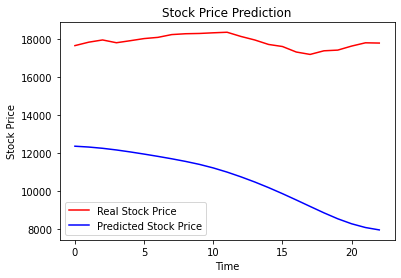

In [92]:
plt.plot(real_stock_price,color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price,color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()